In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
0,NC(=O)c1c(-c2ccc(NC(=O)c3cccc(C(F)(F)F)c3)cc2)...,5.34,576.601,3.44580,0.304138
1,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1,6.40,396.447,4.36090,0.549502
2,CC(=O)Nc1cn2nc(Oc3cccc(NC(=O)c4cccc(F)c4)c3)cc...,8.96,405.389,3.87140,0.525306
3,COc1cc(OC)cc(-c2cc3c[nH]c(=NCCCCO)cc3[nH]c2=NC...,8.10,467.570,3.26220,0.398199
4,Cc1cccc(NC(=O)Nc2ccc(-c3csc4[nH]cnc(=N)c34)cc2...,7.72,393.447,4.86239,0.399977
...,...,...,...,...,...
1636,Cc1[nH]nc2nccc(-c3ccc(NC(=O)Nc4cccnc4)cc3)c12,5.51,344.378,3.97232,0.523798
1637,O=C(Nc1ccc(F)cc1)C1(C(=O)Nc2ccc(Oc3cc[nH]c(=Nc...,6.59,501.493,5.07000,0.307360
1638,CCOC(=O)N=c1s[nH]c(-c2ccc(NC(=O)Nc3cc(C)ccc3F)...,7.30,457.487,3.99082,0.459966
1639,O=C(CSc1nc2ccccc2n2cnnc12)Nc1ccc(C(=O)N=c2ccc(...,8.41,489.948,3.73090,0.363128


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,NC(=O)c1c(-c2ccc(NC(=O)c3cccc(C(F)(F)F)c3)cc2)...,5.34,576.601,3.44580,0.304138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCCCNC(=O)Nc1ccc(Oc2ncnc3cc(OC)c(OC)cc23)cc1,6.40,396.447,4.36090,0.549502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)Nc1cn2nc(Oc3cccc(NC(=O)c4cccc(F)c4)c3)cc...,8.96,405.389,3.87140,0.525306,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc(OC)cc(-c2cc3c[nH]c(=NCCCCO)cc3[nH]c2=NC...,8.10,467.570,3.26220,0.398199,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Cc1cccc(NC(=O)Nc2ccc(-c3csc4[nH]cnc(=N)c34)cc2...,7.72,393.447,4.86239,0.399977,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1636,Cc1[nH]nc2nccc(-c3ccc(NC(=O)Nc4cccnc4)cc3)c12,5.51,344.378,3.97232,0.523798,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1637,O=C(Nc1ccc(F)cc1)C1(C(=O)Nc2ccc(Oc3cc[nH]c(=Nc...,6.59,501.493,5.07000,0.307360,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1638,CCOC(=O)N=c1s[nH]c(-c2ccc(NC(=O)Nc3cc(C)ccc3F)...,7.30,457.487,3.99082,0.459966,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1639,O=C(CSc1nc2ccccc2n2cnnc12)Nc1ccc(C(=O)N=c2ccc(...,8.41,489.948,3.73090,0.363128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Now incorporate this sort of noise into df during the training

In [7]:
X.shape

(1641, 20488)

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample
    
    
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.6749015161981464, pvalue=3.8063002756306504e-23)
PearsonRResult(statistic=0.7087830135153614, pvalue=2.46948979995506e-26)
PearsonRResult(statistic=0.7333049362451232, pvalue=6.096295566540765e-29)
PearsonRResult(statistic=0.7168990488142655, pvalue=3.632099327002964e-27)
PearsonRResult(statistic=0.7883548027839928, pvalue=5.262871375888596e-36)
PearsonRResult(statistic=0.7530022336435647, pvalue=2.966413635893917e-31)
PearsonRResult(statistic=0.8006003839337792, pvalue=7.212729030302515e-38)
PearsonRResult(statistic=0.8196116351996611, pvalue=4.929297743522531e-41)
PearsonRResult(statistic=0.7907449743489112, pvalue=1.422052837846219e-36)


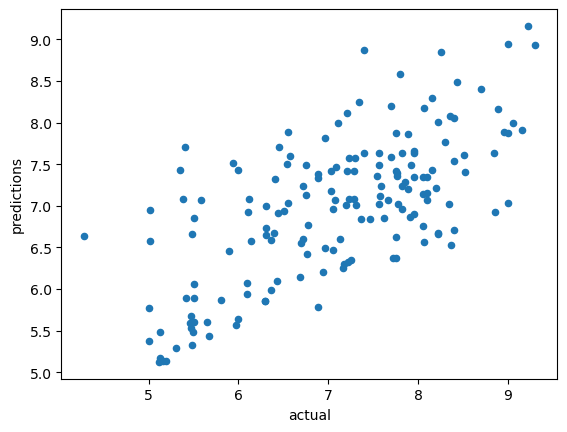

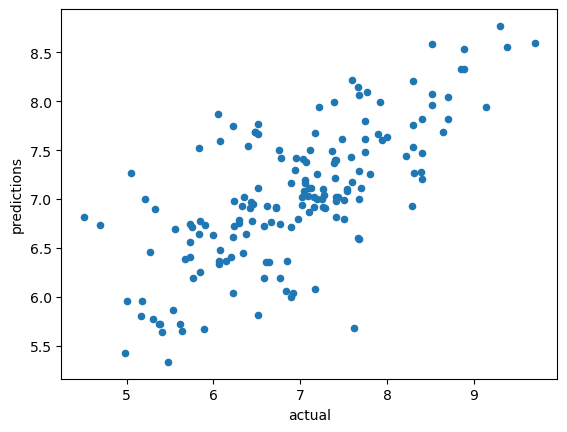

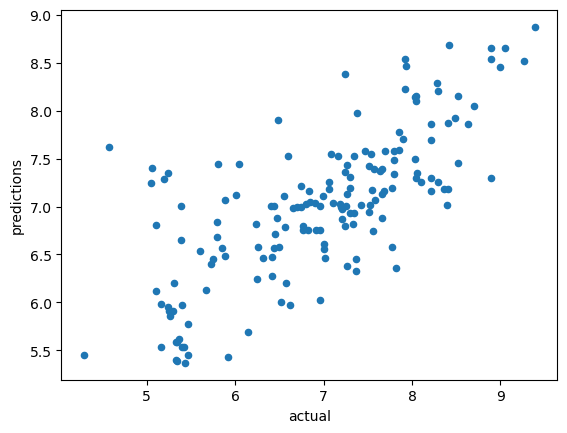

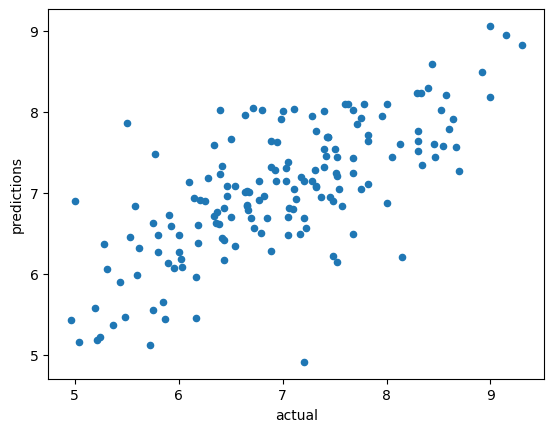

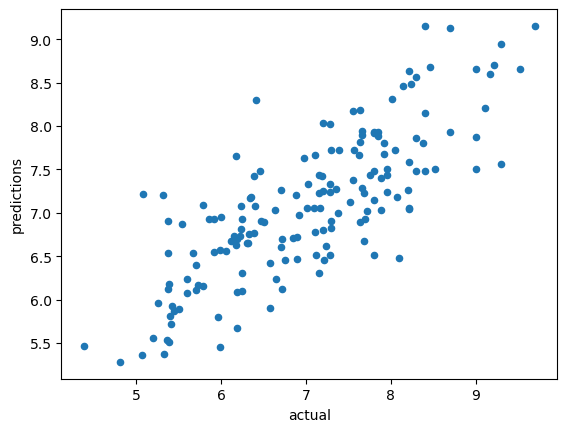

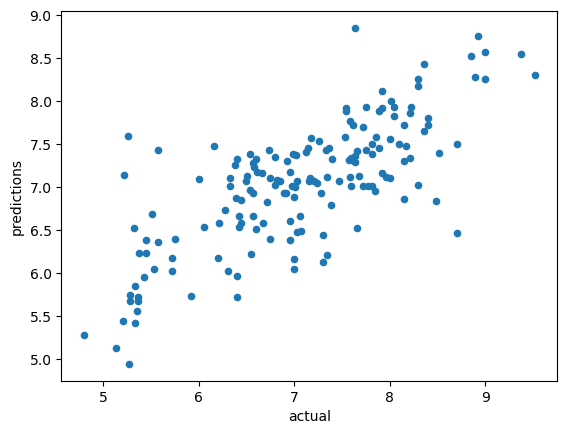

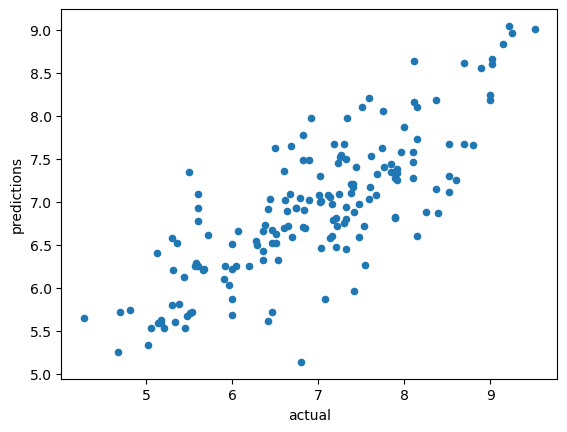

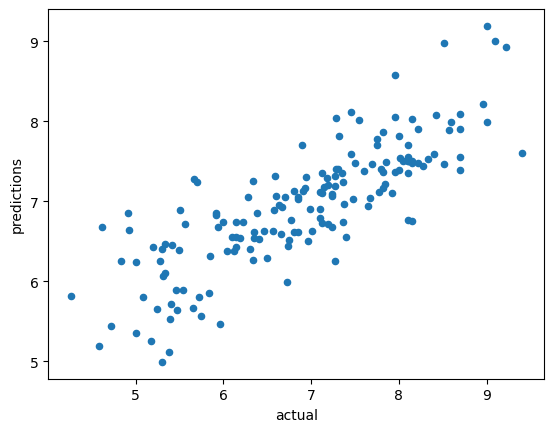

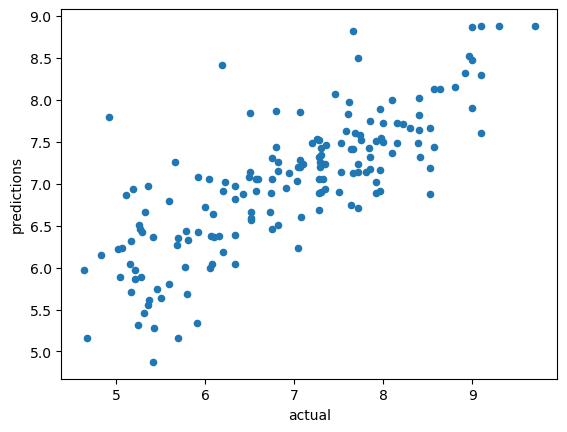

In [9]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [10]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(4, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(1, 3)
(0, 3)
(1, 3)
(1, 3)


In [11]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(0, 3)
(0, 3)
(0, 3)
(3, 3)
(0, 3)
(1, 3)
(1, 3)
(2, 3)
(2, 3)


In [12]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(6, 3)
(7, 3)
(8, 3)
(3, 3)
(5, 3)
(1, 3)
(10, 3)
(10, 3)
(11, 3)


In [13]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(154, 3)
(157, 3)
(155, 3)
(157, 3)
(159, 3)
(161, 3)
(153, 3)
(150, 3)
(151, 3)


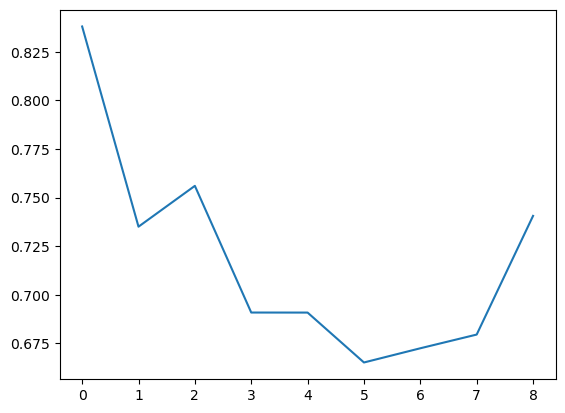

[0.8380721086190677, 0.7350337322100885, 0.7560458293028336, 0.6908464442060722, 0.6908241463074927, 0.6651424686392349, 0.6724539660730225, 0.6795101243916556, 0.7405872653949761]


In [14]:
plt.plot(rmse)
plt.show()
print(rmse)

In [15]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

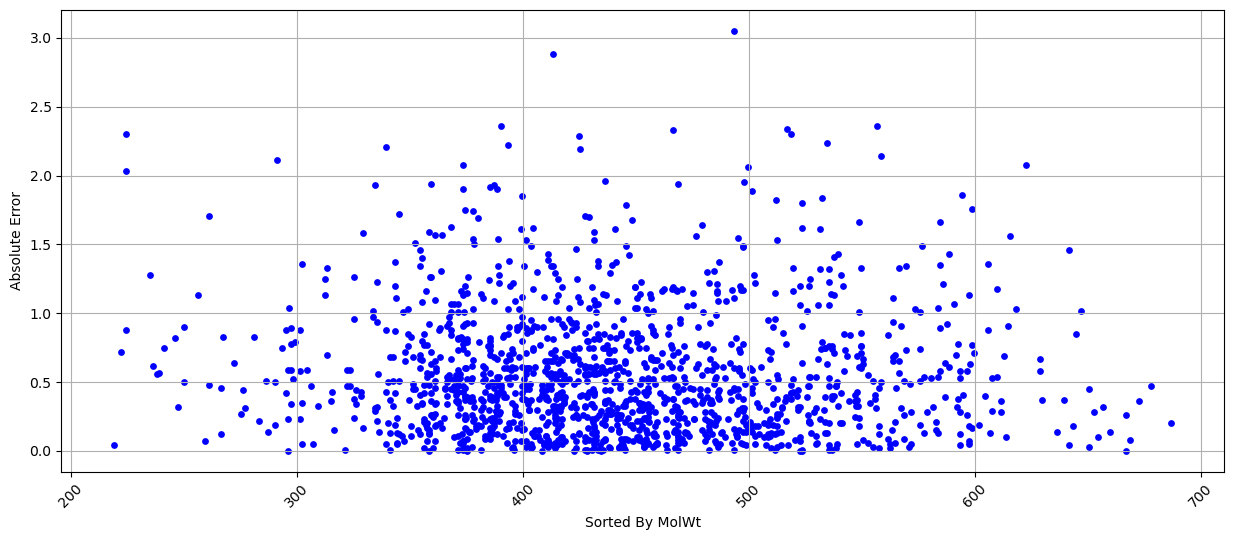

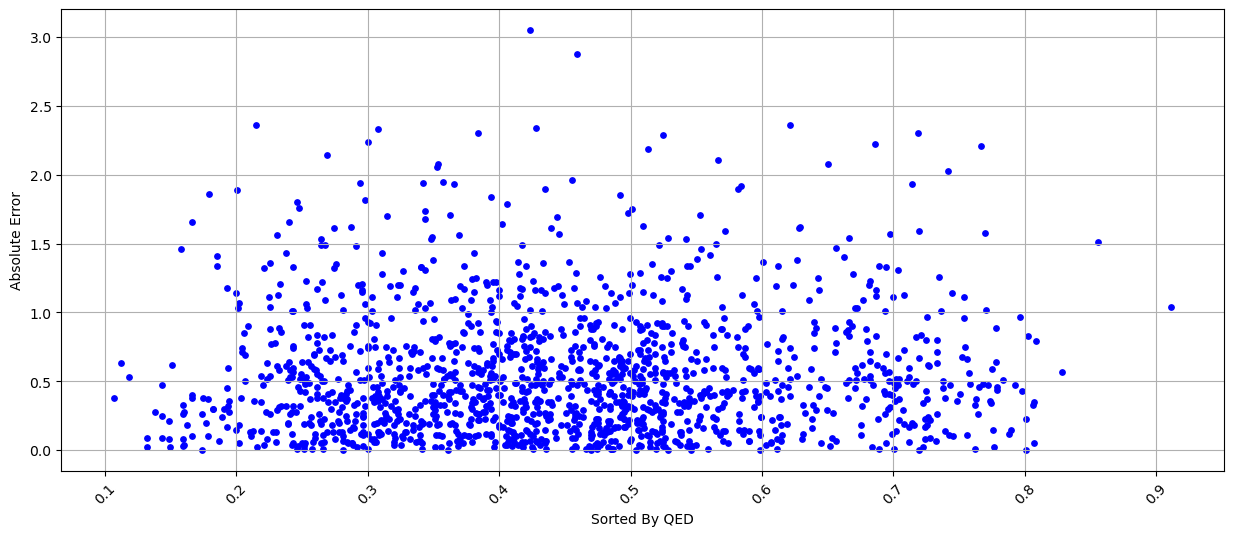

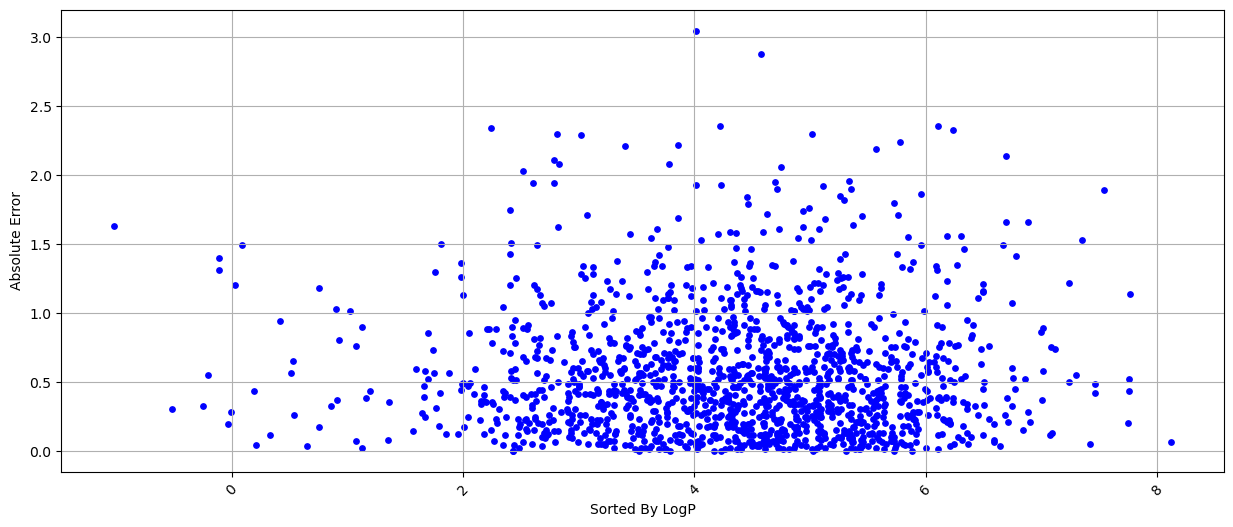

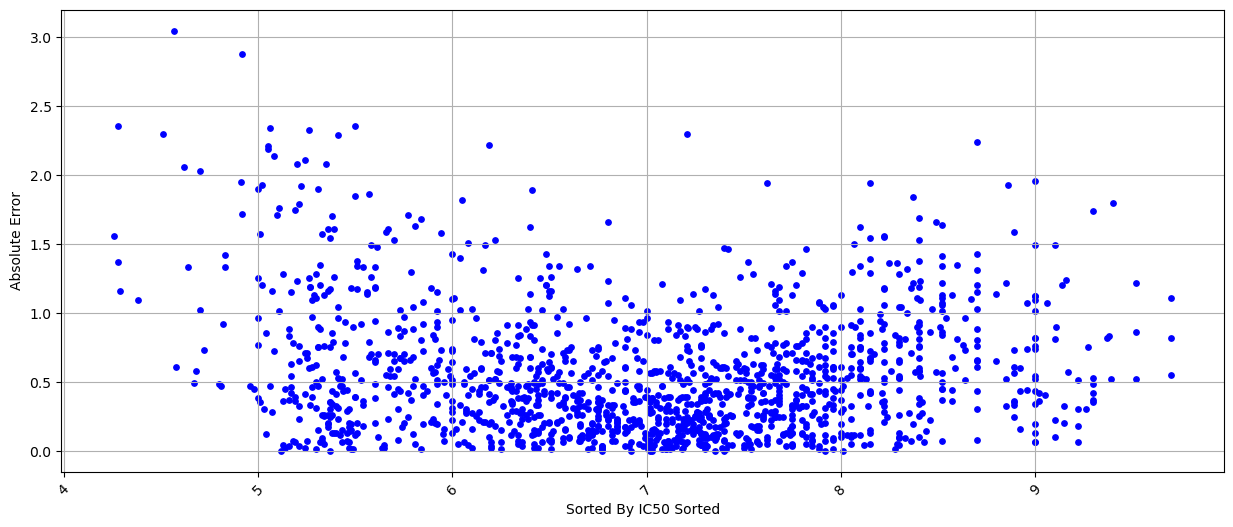

In [16]:
plot_graphs(df, results_df)

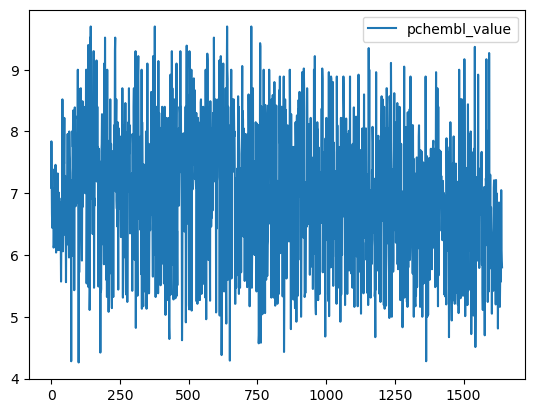

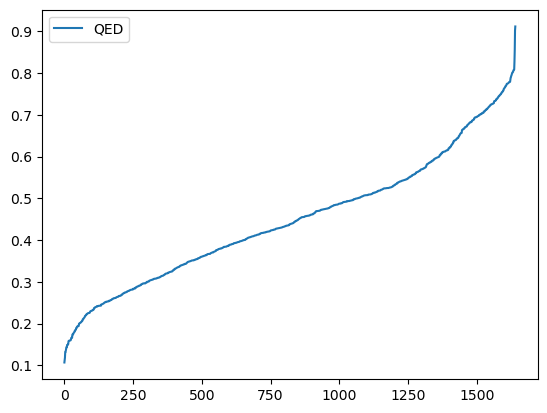

In [17]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [18]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = xgb.XGBRegressor(n_estimators=min(25, round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_xgboost_training batches_druglike.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_xgboost_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.5008486799645412, pvalue=8.498144104517747e-12)
PearsonRResult(statistic=0.5067250909538625, pvalue=4.419260204054007e-12)
PearsonRResult(statistic=0.5901982823698183, pvalue=9.05152627952639e-17)
PearsonRResult(statistic=0.6024764049021879, pvalue=1.4078632532174304e-17)
PearsonRResult(statistic=0.6128682283356952, pvalue=2.7347768273955063e-18)
PearsonRResult(statistic=0.6466036879670591, pvalue=8.613932177965678e-21)
PearsonRResult(statistic=0.6616362338985387, pvalue=5.200670800627097e-22)
PearsonRResult(statistic=0.65265519630331, pvalue=2.8360715756013876e-21)
PearsonRResult(statistic=0.5960442499967886, pvalue=3.7690260218590767e-17)


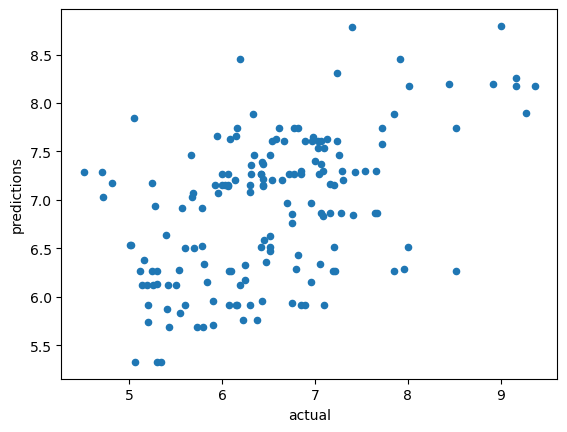

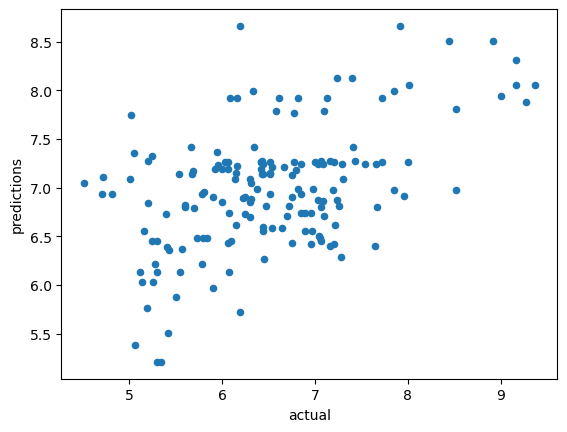

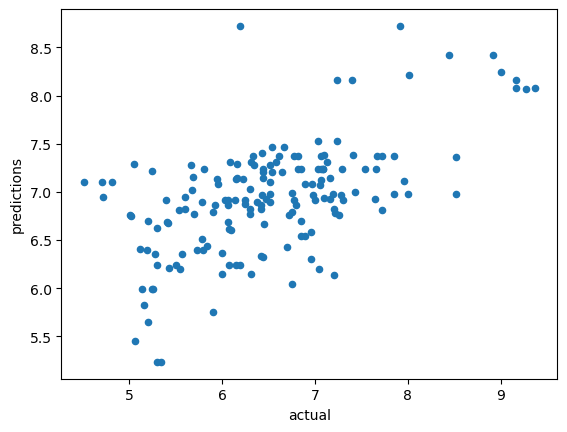

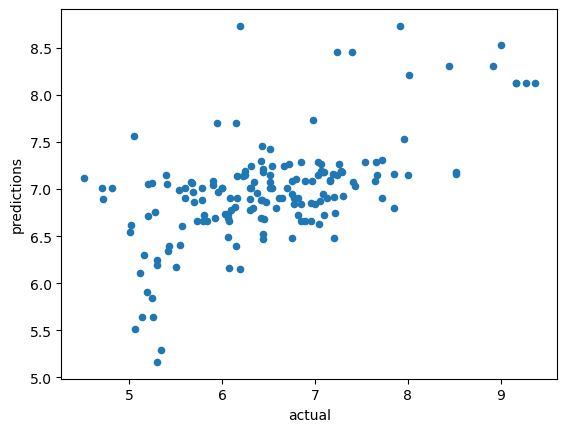

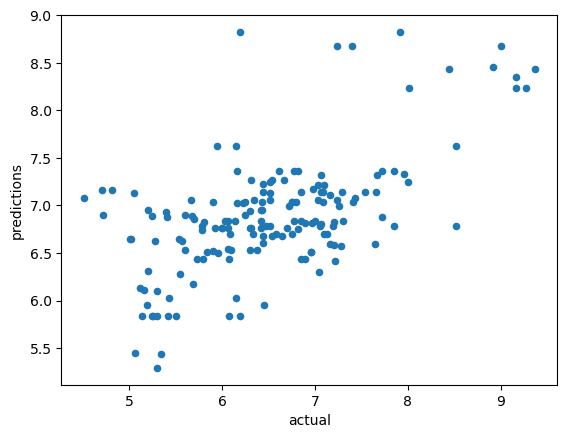

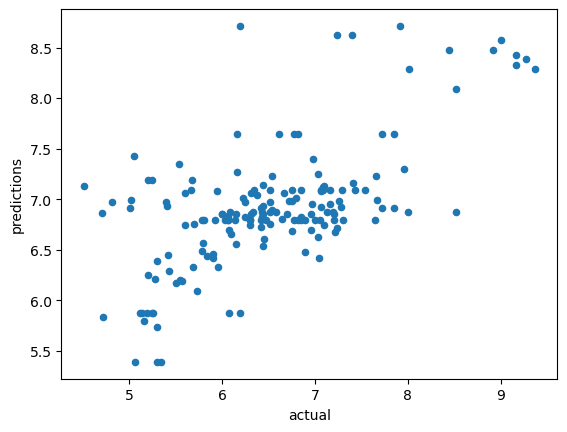

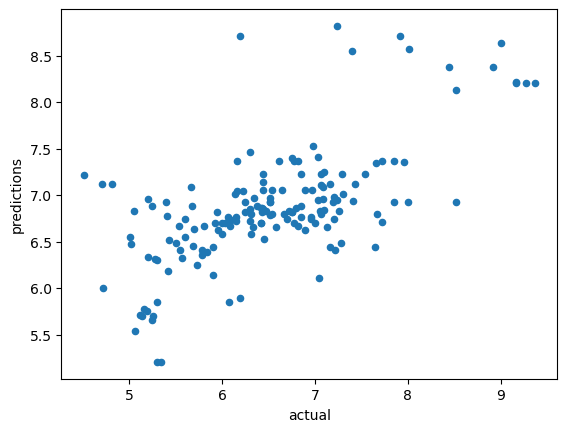

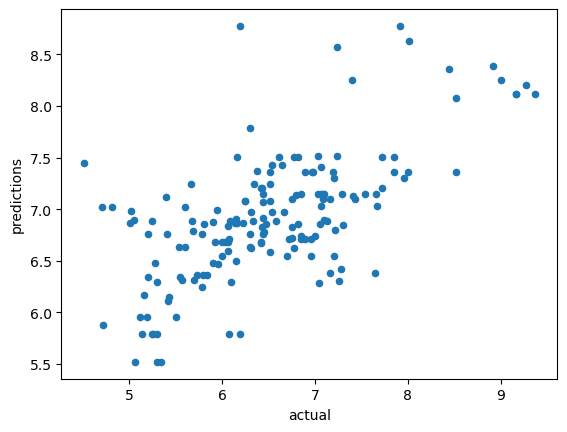

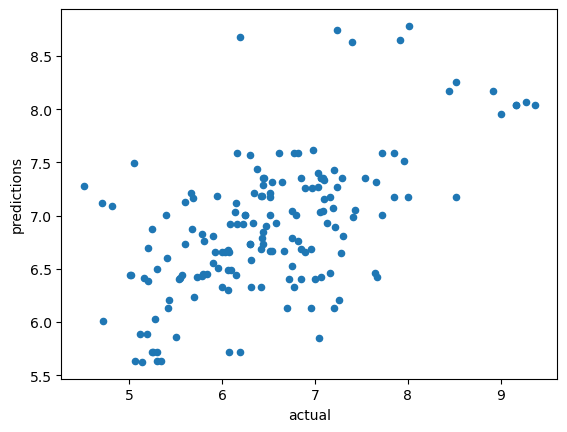

In [19]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

In [20]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [21]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [22]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(150, 3)
(150, 3)
(150, 3)
(149, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)
(150, 3)


In [23]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)
(12, 3)


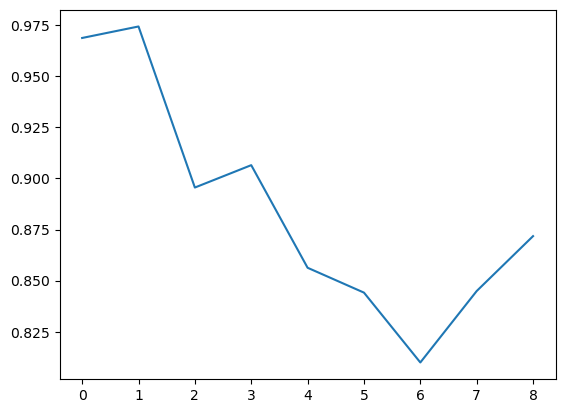

[0.9686878441260679, 0.9743105738536468, 0.8955394409386536, 0.9064819600145988, 0.8563013703021279, 0.8441419476863882, 0.8099753403700028, 0.8449159199746537, 0.8717704233951323]


In [24]:
plt.plot(rmse)
plt.show()
print(rmse)